In [1]:
from hypecommons import *
from hypecommons import plot as hyplot

from datetime import datetime, timedelta

In [3]:
freq = 1
TARGET = 0.02

In [22]:
df = download_history_fast('BNBBUSD', '20210101000000', freq=freq, days=150)

In [23]:
df.iloc[0]

open      37.4121
high      37.4258
low       37.3931
close     37.4160
volume    91.8900
trades    30.0000
Name: 2021-01-01 00:00:00, dtype: float64

The question we want to answer is the following. How long does it take to reach +2% gain from now?

In [24]:
def minutes_to_target(df, start, target):
    t0 = df.index[start]
    close0 = df['close'].iloc[start]
    try:
        t1 = df[(df.index > t0) & (df['close'] >= (1 + target) * close0)].index[0]
    except IndexError:
        return None, None # it never achieves the target
    return t1, round((t1 - t0).total_seconds() / 60.0)

minutes_to_target(df, 0, target=TARGET)

(Timestamp('2021-01-01 10:03:00'), 603)

In [25]:
from tqdm.notebook import tqdm

mins2tgt = []

rng = range(len(df))[::100]

for i in tqdm(rng):
    t, y = minutes_to_target(df, i, target=TARGET)
    if y:
        mins2tgt.append(y)

In [26]:
df_m = pd.DataFrame(mins2tgt)
print((len(df_m[df_m[0] <= 600]), len(df_m)))

(1312, 2068)


In 1312 cases out of 2068 (~63%), 2% gain is reached after less than 10 hours.

First 10 bins: [336. 241. 174. 125. 114.  97.  71.  61.  51.  37.]


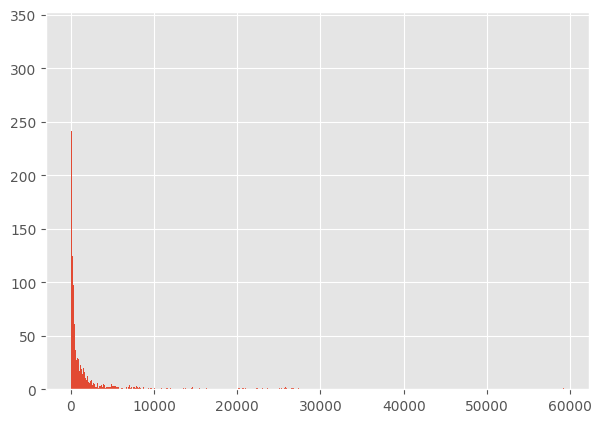

In [27]:
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

hist_x, hist_y, hist_z = plt.hist(mins2tgt, bins=1000)

print(f"First 10 bins: {hist_x[:10]}")

Each bin represents around 60000/1000 = 60 minutes = 1 hour of time, which means (336)/2068 = 16% of the time we reach +2% gain within 1 hour, (336+241)/2068 = 27% of the time within 2 hours, and so on.

In [41]:
def ema(data, n):
    alpha = 2 / (1 + n)
    return data.ewm(alpha=alpha, adjust=False).mean()

def normalise(df_orig):
    df = df_orig.copy()
    
    fields = list(df)
    
    for field in fields:
        if field in ['volume', 'trades']:
            for ma in [1, 3, 9]:
                df[f"{field}_pm_ma{ma}"] = df[field].rolling(window=ma).mean() / freq
        else:
            if field != 'close':
                df[f"{field}_norm"] = df[field] / df['close']

        if field != 'close':
            df.drop(field, axis=1, inplace=True)
    
    for x in [50, 200]:
        df[f"close_ma{x}_norm"] = df['close'].rolling(window=x).mean() / df['close']
    
    for x in [12, 26]:
        df[f"close_ema{x}_norm"] = ema(df['close'], x) / df['close']
    
    df.drop('close', axis=1, inplace=True)
    df.dropna(inplace=True)
    return df

df_n = normalise(df)
df_n

,open_norm,high_norm,low_norm,volume_pm_ma1,volume_pm_ma3,volume_pm_ma9,trades_pm_ma1,trades_pm_ma3,trades_pm_ma9,close_ma50_norm,close_ma200_norm,close_ema12_norm,close_ema26_norm
2021-01-01 03:19:00,0.999544,1.000000,0.999054,118.0100,87.053333,64.607778,27.0,18.666667,15.555556,0.997564,0.990276,0.998454,0.998277
2021-01-01 03:20:00,0.999116,1.000142,0.999116,113.5700,108.116667,76.055556,30.0,26.000000,18.333333,0.996912,0.989546,0.998005,0.997653
2021-01-01 03:21:00,1.000500,1.000550,1.000000,67.6100,99.730000,77.811111,9.0,22.000000,18.111111,0.997589,0.990138,0.998757,0.998313
2021-01-01 03:22:00,0.999816,1.000000,0.999534,80.3700,87.183333,82.741111,14.0,17.666667,18.000000,0.997192,0.989674,0.998485,0.997932
2021-01-01 03:23:00,1.000232,1.000487,0.999644,53.4300,67.136667,82.126667,25.0,16.000000,19.222222,0.998062,0.990486,0.999341,0.998767
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31 00:56:00,0.998772,1.000676,0.998434,175.7773,215.617600,295.126289,107.0,122.333333,151.888889,1.001310,1.010835,0.999641,1.000626
2021-05-31 00:57:00,0.998498,1.000521,0.998498,137.2728,160.450300,260.245622,127.0,111.333333,143.777778,0.999698,1.009088,0.998322,0.999074
2021-05-31 00:58:00,1.000245,1.000307,0.998651,92.0236,135.024567,234.063278,76.0,103.333333,136.111111,0.999543,1.008746,0.998373,0.998916
2021-05-31 00:59:00,1.000951,1.001166,0.999018,425.4814,218.259267,246.166967,102.0,101.666667,126.888889,1.000659,1.009697,0.999505,0.999961
